In [1]:
import sys
sys.path.append("Methods/EWC/old")

In [2]:
from lib.abstract_torch import get_device, get_optimizer, get_loss
from lib.benchmark_generator import PermutedMNIST
from lib.models import ANN
from lib.train import train
from lib.test import test
from lib.visualize import vizualize_loss_hists, visualize_accs_matrix, visualize_avg_acc_curve

import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from avalanche.training.supervised import EWC
from avalanche.training.plugins import EWCPlugin
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, forgetting_metrics
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin

/home/mathis/miniconda3/envs/.jax_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "/data"

In [4]:
device = get_device(1)

## Set parameters

In [5]:
# Benchmark parameter
num_tasks = 3
train_percentage = 0.3

# EWC parameter
ewc_lambda = 400

# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden_root = 1000
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

# Hyperparameters
num_epochs = 3
lr = 1e-3

## Reproducibility

In [6]:
random_seed = 88

## Get p-MNIST benchmark

In [7]:
benchmark = PermutedMNIST(n_experiences=num_tasks, train_percentage=train_percentage, difficulty="hard", seed=random_seed)

## Define model

In [8]:
model = ANN(num_inputs, num_hidden_root, num_outputs, random_seed).to(device)

## Train with EWC

In [9]:
optimizer = get_optimizer(optimizer_name, model)

In [10]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True, trained_experience = True),
    loggers=[InteractiveLogger()]
)

ewc = EWC(
    model, optimizer, criterion=get_loss(loss_name), ewc_lambda=ewc_lambda,
    train_mb_size=batch_size, train_epochs=num_epochs, eval_mb_size=batch_size, evaluator=eval_plugin,
    device=device
)

print((ewc.plugins[0].compute_importances(model=model,
                                       criterion=get_loss(loss_name),
                                       optimizer=optimizer,
                                       dataset=experience.dataset,
                                       device=device,
                                       batch_size=128)["fc1.weight"].data> 1e-6).sum())

In [11]:
experience = benchmark.train_stream[0]
ewc.plugins[0].compute_importances(model=model,
                                       criterion=get_loss(loss_name),
                                       optimizer=optimizer,
                                       dataset=experience.dataset,
                                       device=device,
                                       batch_size=128)["fc1.weight"].data

tensor([[8.0730e-08, 1.4048e-07, 4.1409e-07,  ..., 8.0626e-08, 9.1909e-07,
         1.5157e-07],
        [1.0740e-07, 2.2721e-07, 4.7967e-07,  ..., 1.0709e-07, 9.3812e-07,
         3.3623e-07],
        [1.0950e-07, 5.4087e-07, 4.5733e-07,  ..., 1.0870e-07, 1.4194e-06,
         2.8137e-07],
        ...,
        [5.1850e-08, 2.3018e-07, 1.7951e-07,  ..., 5.1633e-08, 6.8149e-07,
         6.5693e-08],
        [4.7026e-08, 2.2223e-07, 3.1159e-07,  ..., 4.6890e-08, 4.3372e-07,
         8.6141e-08],
        [1.3691e-07, 4.4752e-07, 6.3682e-07,  ..., 1.3647e-07, 1.8381e-06,
         1.7989e-07]], device='cuda:1')

In [12]:
ewc.plugins[0].importances

defaultdict(dict, {})

In [13]:
results = []
tr = []
sto = []
test_accs_matrix = np.zeros((num_tasks, num_tasks))
for task_number, train_experience, test_experience in zip(list(range(num_tasks)), benchmark.train_stream, benchmark.test_stream) :
    ewc.train(train_experience)
    sto.append(ewc.plugins[0].importances[0])
    break
    #results.append(ewc.eval(test_experience))
    #test_dataset = test_experience.dataset
    #test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)
    #tr.append(test(model, test_data_loader, batch_size, device=device))
    #for j in range(num_tasks) :
    #        test_accs_matrix[task_number,j] = round(test(model, test_loaders_list[j], device),2)

-- >> Start of training phase << --
0it [00:00, ?it/s]

100%|██████████| 141/141 [00:02<00:00, 67.86it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8372
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8875
100%|██████████| 141/141 [00:02<00:00, 69.83it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9524
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9750
100%|██████████| 141/141 [00:02<00:00, 68.22it/s]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9672
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9875
-- >> End of training phase << --


In [14]:
sto[0]["fc1.weight"].data[0,:5]

tensor([3.1795e-08, 6.9682e-08, 8.3742e-08, 1.1824e-07, 2.3849e-07],
       device='cuda:1')

In [15]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True, trained_experience = True),
    loggers=[InteractiveLogger()]
)

ewc = EWC(
    model, optimizer, criterion=get_loss(loss_name), ewc_lambda=ewc_lambda,
    train_mb_size=batch_size, train_epochs=num_epochs, eval_mb_size=batch_size, evaluator=eval_plugin,
    device=device
)

In [16]:
ewc.plugins[0].importances[0]
ewc.plugins[3].train_exp_counter

0

In [17]:
ewc.plugins[0].importances[0] = sto[0]
ewc.plugins[3].train_exp_counter = 1

In [18]:
ewc.plugins[0].importances[0]
ewc.plugins[3].train_exp_counter

1

In [19]:
resto = []
for task_number, train_experience, test_experience in zip(list(range(num_tasks)), benchmark.train_stream, benchmark.test_stream) :
    if task_number != 0:
        ewc.train(train_experience)
        resto.append(ewc.plugins[0].importances)

-- >> Start of training phase << --
  9%|▉         | 13/141 [00:00<00:02, 56.90it/s]

100%|██████████| 141/141 [00:02<00:00, 70.15it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8508
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8625
100%|██████████| 141/141 [00:01<00:00, 70.62it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9456
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9875
100%|██████████| 141/141 [00:02<00:00, 70.37it/s]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9652
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9500
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 141/141 [00:02<00:00, 68.52it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8578
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9000
100%|██████████| 141/141 [00:02<00:00, 67.44it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9458
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9375
100%|██████████| 141/141 [00:02<00:00, 6

In [24]:
resto[0][0]["fc1.weight"].data[0,:5]

tensor([3.1795e-08, 6.9682e-08, 8.3742e-08, 1.1824e-07, 2.3849e-07],
       device='cuda:1')

## Visualize results

In [21]:
test_accs_matrix = np.zeros((num_tasks,num_tasks))
for i,r in enumerate(results) :
    for j in range(num_tasks) :
        test_accs_matrix[i][j] = r[f'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{j}']*100

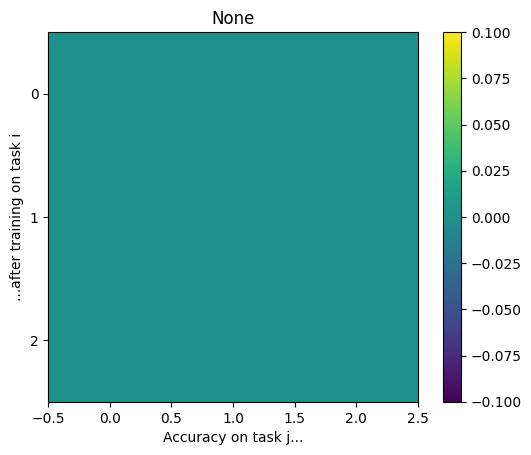

In [22]:
visualize_accs_matrix(test_accs_matrix)

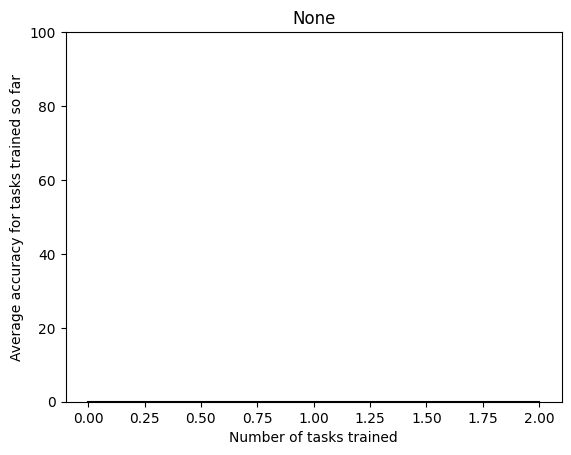

In [23]:
visualize_avg_acc_curve(test_accs_matrix)